In [1]:
import multiprocessing as mp
from datetime import datetime
import sys
sys.path.insert(0, '../../data/siim-pneumothorax')

import torch
import torch.nn as nn
import torch.nn.functional as F

import fastai
from fastai.vision import *
from mask_functions import *

fastai.__version__

'1.0.54'

In [2]:
SZ = 256
path = Path(f'../../data/siim-pneumothorax/')
torch.cuda.set_device('cuda:0')

#eliminate all predictions with a few (noise_th) pixesls
noise_th = 75.0*(SZ/128.0)**2 #threshold for the number of predicted pixels
best_thr0 = 0.2 #preliminary value of the threshold for metric calculation

In [3]:
SEED = 2019

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

In [4]:
# custom model

class ConvBn2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, dilation=1, stride=1, groups=1, is_bn=True):
        super(ConvBn2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation, groups=groups, bias=False)
        #self.bn = SynchronizedBatchNorm2d(out_channels)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, z):
        x = self.conv(z)
        x = self.bn(x)
        return x

class sSE(nn.Module):
    def __init__(self, out_channels):
        super(sSE, self).__init__()
        self.conv = ConvBn2d(in_channels=out_channels,out_channels=1,kernel_size=1,padding=0)
    def forward(self,x):
        x=self.conv(x)
        #print('spatial',x.size())
        x=F.sigmoid(x)
        return x

class cSE(nn.Module):
    def __init__(self, out_channels):
        super(cSE, self).__init__()
        self.conv1 = ConvBn2d(in_channels=out_channels,out_channels=int(out_channels/2),kernel_size=1,padding=0)
        self.conv2 = ConvBn2d(in_channels=int(out_channels/2),out_channels=out_channels,kernel_size=1,padding=0)
    def forward(self,x):
        x=nn.AvgPool2d(x.size()[2:])(x)
        #print('channel',x.size())
        x=self.conv1(x)
        x=F.relu(x)
        x=self.conv2(x)
        x=F.sigmoid(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, in_channels, channels, out_channels):
        super(Decoder, self).__init__()
        self.conv1 = ConvBn2d(in_channels, channels, kernel_size=3, padding=1)
        self.conv2 = ConvBn2d(channels, out_channels, kernel_size=3, padding=1)
        self.spatial_gate = sSE(out_channels)
        self.channel_gate = cSE(out_channels)

    def forward(self, x, e=None):
        x = F.upsample(x, scale_factor=2, mode='bilinear', align_corners=True)
        #print('x',x.size())
        #print('e',e.size())
        if e is not None:
            x = torch.cat([x,e],1)

        x = F.relu(self.conv1(x),inplace=True)
        x = F.relu(self.conv2(x),inplace=True)
        #print('x_new',x.size())
        g1 = self.spatial_gate(x)
        #print('g1',g1.size())
        g2 = self.channel_gate(x)
        #print('g2',g2.size())
        x = g1*x + g2*x

        return x
    
class Unet_scSE_hyper(nn.Module):

    def criterion3(self,logit, truth):
        logit = logit.squeeze(1)
        truth = truth.squeeze(1)
        loss = L.lovasz_hinge_relu(logit, truth, per_image=True, ignore=None)
        return loss

    def criterion(self,logit, truth):
        logit = logit.squeeze(1)
        truth = truth.squeeze(1)
        loss = L.lovasz_hinge(logit, truth, per_image=True, ignore=None)
        return loss
    
    def criterion2(self,logit, truth):
        metric = torch.nn.BCEWithLogitsLoss(size_average=True, reduction='none')
        logit = logit.squeeze(1)
        truth = truth.squeeze(1)
        loss = metric(logit, truth)
        return loss
    
    def focal_loss(self, output, target, alpha, gamma, OHEM_percent):
        output = output.contiguous().view(-1)
        target = target.contiguous().view(-1)

        max_val = (-output).clamp(min=0)
        loss = output - output * target + max_val + ((-max_val).exp() + (-output - max_val).exp()).log()

        # This formula gives us the log sigmoid of 1-p if y is 0 and of p if y is 1
        invprobs = F.logsigmoid(-output * (target * 2 - 1))
        focal_loss = alpha * (invprobs * gamma).exp() * loss

        # Online Hard Example Mining: top x% losses (pixel-wise). Refer to http://www.robots.ox.ac.uk/~tvg/publications/2017/0026.pdf
        OHEM, _ = focal_loss.topk(k=int(OHEM_percent * [*focal_loss.shape][0]))
        return OHEM.mean() 

    def __init__(self, pretrained):
        super().__init__()
        self.resnet = models.resnet34(pretrained=True)

        self.conv1 = nn.Sequential(
            self.resnet.conv1,
            self.resnet.bn1,
            self.resnet.relu,
        )

        self.encoder2 = self.resnet.layer1 # 64
        self.encoder3 = self.resnet.layer2 #128
        self.encoder4 = self.resnet.layer3 #256
        self.encoder5 = self.resnet.layer4 #512

        self.center = nn.Sequential(
            ConvBn2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            ConvBn2d(512,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )

        self.decoder5 = Decoder(256+512,512,64)
        self.decoder4 = Decoder(64 +256,256,64)
        self.decoder3 = Decoder(64 +128,128,64)
        self.decoder2 = Decoder(64 +64 ,64 ,64)
        self.decoder1 = Decoder(64     ,32 ,64)
        
        self.dropout = nn.Dropout2d(p=0.5)

        self.logit = nn.Sequential(
            nn.Conv2d(384, 64, kernel_size=3, padding=1),
            nn.ELU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1, padding=0),
        )

    def forward(self, x):
        mean=[0.485, 0.456, 0.406]
        std=[0.229,0.224,0.225]
        x=torch.cat([
           (x-mean[2])/std[2],
           (x-mean[1])/std[1],
           (x-mean[0])/std[0],
        ],1)
        '''
        x=torch.cat([
           x,
           x,
           x
        ],1)
        '''

        e1 = self.conv1(x)
        #print(e1.size())
        e2 = self.encoder2(e1)
        #print('e2',e2.size())
        e3 = self.encoder3(e2)
        #print('e3',e3.size())
        e4 = self.encoder4(e3)
        #print('e4',e4.size())
        e5 = self.encoder5(e4)
        #print('e5',e5.size())

        f = self.center(e5)
        #print('f',f.size())
        d5 = self.decoder5(f, e5)
        d4 = self.decoder4(d5,e4)
        d3 = self.decoder3(d4,e3)
        d2 = self.decoder2(d3,e2)
        d1 = self.decoder1(d2)
        #print('d1',d1.size())

        f = torch.cat((
            F.upsample(e1,scale_factor= 2, mode='bilinear',align_corners=False),
            d1,
            F.upsample(d2,scale_factor= 2, mode='bilinear',align_corners=False),
            F.upsample(d3,scale_factor= 4, mode='bilinear',align_corners=False),
            F.upsample(d4,scale_factor= 8, mode='bilinear',align_corners=False),
            F.upsample(d5,scale_factor=16, mode='bilinear',align_corners=False),
        ),1)
        #print('hc',f.size())

        f = self.dropout2d(f)
        logit = self.logit(f)
        return logit


    def criterion1(self, logit, truth ):
        loss = FocalLoss2d(gamma=0.5)(logit, truth, type='sigmoid')
        return loss

    # def criterion(self,logit, truth):
    #     loss = F.binary_cross_entropy_with_logits(logit, truth)
    #     return loss

    def metric(self, logit, truth, noise_th, threshold=0.2 ):
        prob = torch.sigmoid(logit)
        # dice = dice_accuracy(prob, truth, threshold=threshold, is_average=True)
        # dice = accuracy(prob, truth, threshold=threshold, is_average=True)
        dice = dice_metric(prob, truth, noise_th, best_thr=threshold, iou=False, eps=1e-8)
        return dice

    def set_mode(self, mode, is_freeze_bn=False ):
        self.mode = mode
        if mode in ['eval', 'valid', 'test']:
            self.eval()
        elif mode in ['train']:
            self.train()
            if is_freeze_bn==True: ##freeze
                for m in self.modules():
                    if isinstance(m, nn.BatchNorm2d) or isinstance(m,SynchronizedBatchNorm2d):
                        m.eval()
                        m.weight.requires_grad = False
                        m.bias.requires_grad   = False

        else:   
        	raise NotImplementedError

In [5]:
def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    n = targs.shape[0]
    input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    #input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

In [6]:
def get_preds(learn, ds_type=DatasetType.Valid):
    preds = []
    ys = []
    
    model = learn.model
    model.eval()
    
    dl = learn.dl(ds_type)
    
    with torch.no_grad():
        for xb, yb in progress_bar(dl):
            pred = model(xb)
            pred = F.softmax(pred, dim=1)
            
            preds.append(to_detach(pred))
            ys.append(yb.cpu())
            
    del pred
    gc.collect()
    torch.cuda.empty_cache()
    
    return torch.cat(preds),torch.cat(ys)

In [7]:
# Prediction with flip TTA
def pred_with_flip(learn:fastai.basic_train.Learner,
                   ds_type:fastai.basic_data.DatasetType=DatasetType.Valid):
    #get prediction
    # preds, ys = learn.get_preds(ds_type)
    preds, ys = get_preds(learn, ds_type)
    preds = preds[:,1,...]
    
    #add fiip to dataset and get prediction
    learn.data.dl(ds_type).dl.dataset.tfms.append(flip_lr())
    preds_lr, ys = get_preds(learn, ds_type)
    
    del learn.data.dl(ds_type).dl.dataset.tfms[-1]
    
    preds_lr = preds_lr[:,1,...]
    ys = ys.squeeze()
    preds = 0.5*(preds + torch.flip(preds_lr,[-1]))
    
    del preds_lr
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return preds, ys

In [8]:
# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

In [9]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train_png')
        .split_by_rand_pct(0.2)
        .label_from_func(lambda x : str(x).replace('train', 'mask'), classes=[0, 1])
        .add_test((path/'test_png').ls(), label=None)
        .transform(get_transforms(), size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=16)
        .normalize(imagenet_stats))

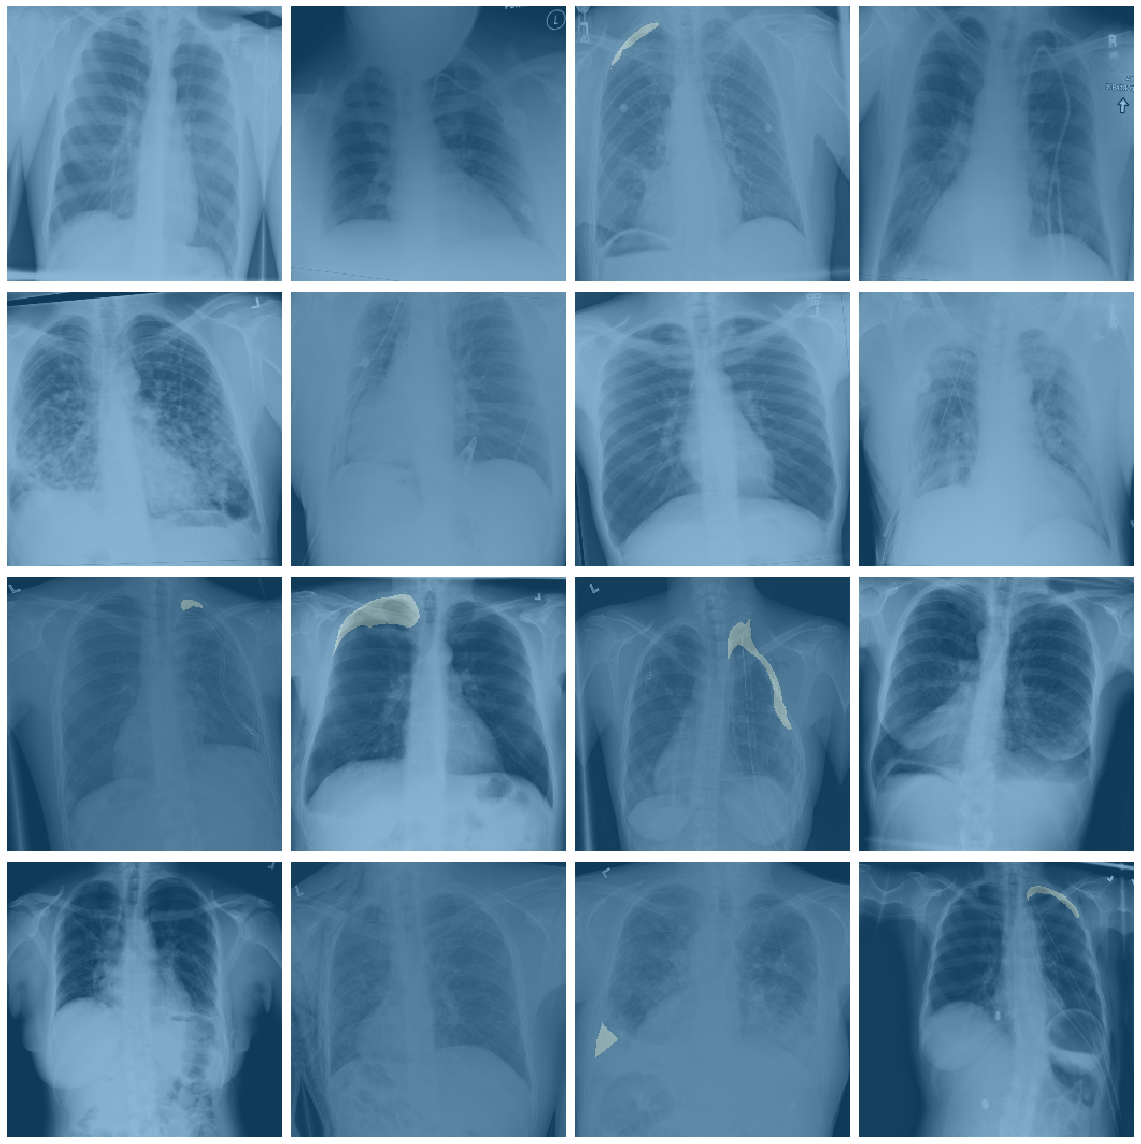

In [10]:
# Display some images with masks
data.show_batch()

In [11]:
# Create U-Net with a pretrained resnet34 as encoder
learn = unet_learner(data, Unet_scSE_hyper, metrics=[dice])

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 3, but got 2-dimensional input of size [1, 1000] instead

In [11]:
# Fit one cycle of 6 epochs with max lr of 1e-3
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,dice,time


KeyboardInterrupt: 

In [8]:
# Unfreeze the encoder (resnet34)
learn.unfreeze()

In [9]:
# Fit one cycle of 12 epochs
lr = 1e-3
learn.fit_one_cycle(48, slice(lr/80, lr))

epoch,train_loss,valid_loss,dice,time
0,0.010879,0.010485,0.243494,03:56
1,0.010041,0.010609,0.181819,03:56
2,0.012561,0.011522,0.096426,03:55
3,0.011901,0.011303,0.078110,03:55
4,0.014285,0.012183,0.020780,03:55
5,0.013472,0.010616,0.231704,03:56
6,0.010675,0.009717,0.247328,03:56
7,0.011916,0.010388,0.205140,03:55
8,0.010571,0.009633,0.280818,03:54
9,0.008906,0.009530,0.243566,03:56


In [36]:
now = datetime.now()
learn.save('unet_{}_{}'.format(now.strftime('%Y%m%d-%H%M%S'), SZ))


## Eval

In [10]:
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

In [11]:
tag = '20190725-171130_256'

# load pretrained model
learn = unet_learner(data, models.resnet34, metrics=[dice])
learn.load('unet_{}'.format(tag))

Learner(data=ImageDataBunch;

Train: LabelList (8570 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../../data/siim-pneumothorax/train_png;

Valid: LabelList (2142 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../../data/siim-pneumothorax/train_png;

Test: LabelList (1377 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ../../data/siim-pneumothorax/train_png, model=DynamicUnet(
  (laye

In [41]:
# Predictions for the validation set
preds, ys = pred_with_flip(learn)
ys = ys.squeeze()

In [42]:
# put tensor on gpu if mem is enough
preds = preds.cuda()
ys = ys.cuda()

In [43]:
#remove noise
preds[preds.view(preds.shape[0],-1).sum(-1) < 75.0*(SZ/128.0)**2,...] = 0.0

In [44]:
# Find optimal threshold
dices = []
params = []

thrs = np.arange(0.01, 1.01, 0.01)
n_thrs = np.arange(1, 101, 1)

for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    
    for n_thr in n_thrs:
        preds_n = preds_m.clone()
        
        preds_n[preds_n.view(preds_n.shape[0],-1).sum(-1) < n_thr*(SZ/128.0)**2,...] = 0.0
        dices.append(dice_overall(preds_n, ys).mean())
        
        params.append((i, n_thr))
        
dices = np.array(dices)
print('best_dice: {} @ {}'.format(dices.max(), params[dices.argmax()]))

best_dice: 0.8152936100959778 @ (0.3, 60)


In [46]:
best_thr, best_nthr = params[dices.argmax()]

In [45]:
best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

print('best_dice: {} @ thr: {}'.format(best_dice, best_thr))

IndexError: index 2959 is out of bounds for axis 0 with size 100

In [32]:
# Find out optimal noise_threshold
preds_n = (preds>best_thr).long()

n_dices = []
n_thrs = np.arange(10, 101, 1)
for n_thr in progress_bar(n_thrs):
    preds_n[preds_n.view(preds_n.shape[0],-1).sum(-1) < n_thr*(SZ/128.0)**2,...] = 0.0
    n_dices.append(dice_overall(preds_n, ys).mean())
n_dices = np.array(n_dices)


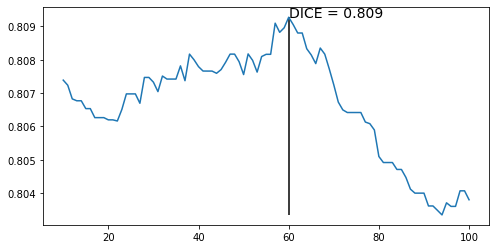

best_noise_dice: 0.8092689514160156 @ thr: 60


In [33]:
best_ndice = n_dices.max()
best_nthr = n_thrs[n_dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(n_thrs, n_dices)
plt.vlines(x=best_nthr, ymin=n_dices.min(), ymax=n_dices.max())
plt.text(best_nthr, best_ndice, f'DICE = {best_ndice:.3f}', fontsize=14);
plt.show()

print('best_noise_dice: {} @ thr: {}'.format(best_ndice, best_nthr))

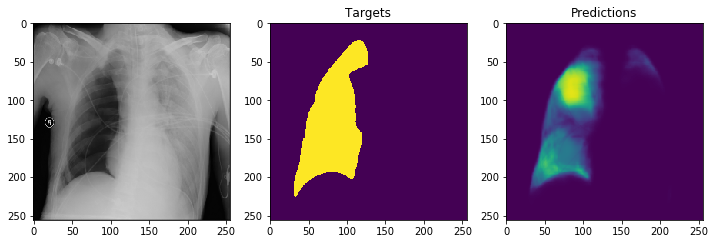

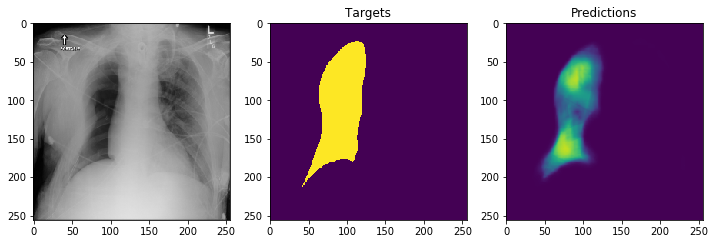

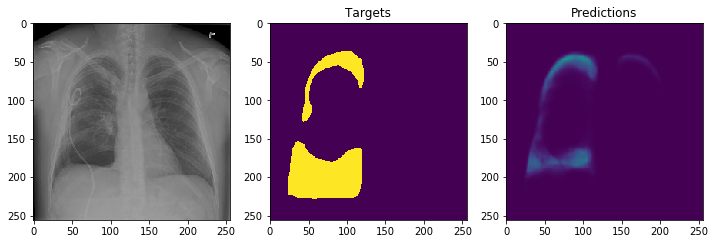

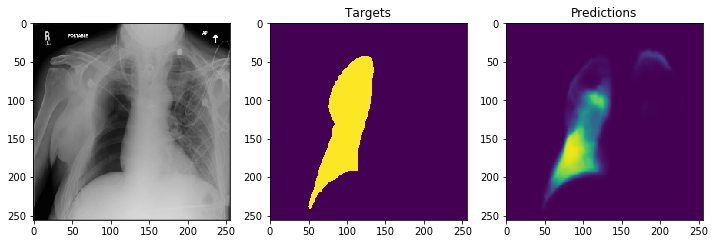

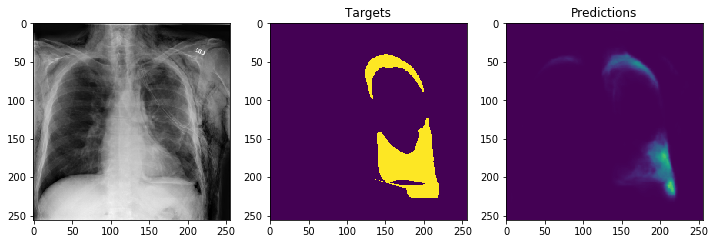

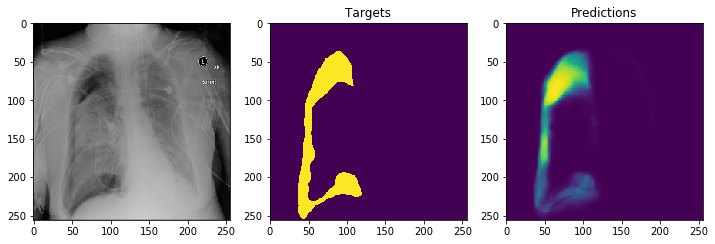

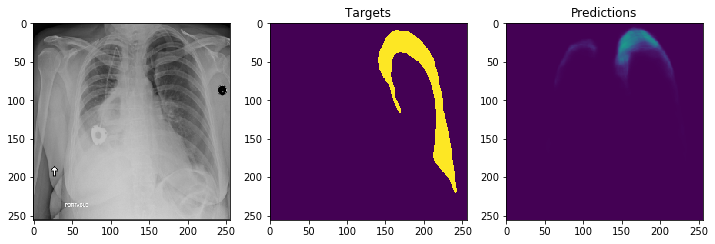

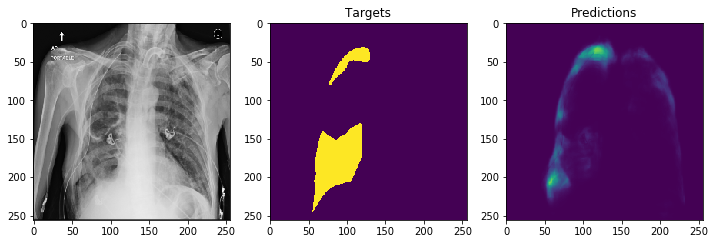

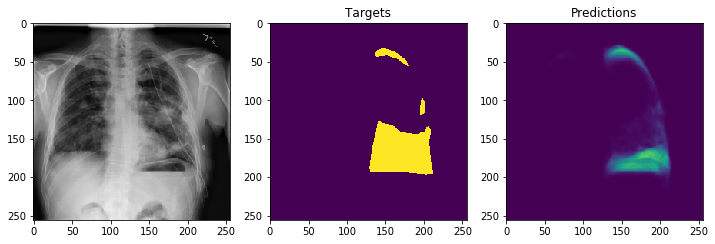

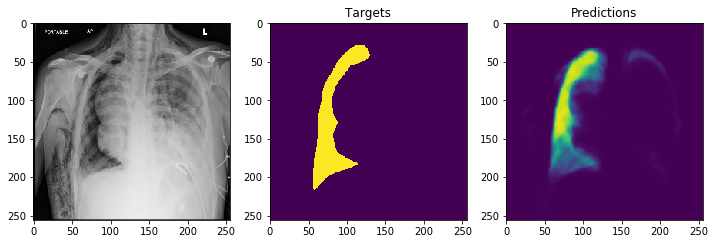

In [19]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

## Test

In [47]:
# Predictions for test set
preds, _ = learn.get_preds(ds_type=DatasetType.Test)


In [48]:
pt_mask = (preds[:,1,...]>best_thr).long()
print(pt_mask.sum(), best_thr)


tensor(163336)


In [49]:
# noise removal
pt_clean = pt_mask.clone()
pt_clean[pt_clean.view(pt_clean.shape[0],-1).sum(-1) < best_nthr*(SZ/128.0)**2,...] = 0.0

print(pt_clean.sum(), best_nthr)
pt_clean = pt_clean.numpy()

tensor(150256)


In [50]:
# Generate rle encodings in parallel (images are first converted to the original size)
mask_size = 1024

def mask_worker(mask):
    im = PIL.Image.fromarray((mask.T*255).astype(np.uint8)).resize((mask_size, mask_size))
    im = np.asarray(im)
    rle = mask2rle(im, mask_size, mask_size)
    
    return rle

pool = mp.Pool()
rles = pool.map(mask_worker, pt_clean)


In [51]:
ids = [o.stem for o in data.test_ds.items]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6106.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6588.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6014.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6813.151787520...,-1
4,1.2.276.0.7230010.3.1.4.8323329.699.1517875164...,-1


In [53]:
sub_df.to_csv('unet_sub.csv', index=False)